## Setup

In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras

In [29]:
def B_vs_V(x:np.array, y1:np.array, y2:np.array, y3:np.array):
    """plots y1, y2, and y3 vs x and returns the corresponding slopes"""
    index = x != 0 # Indexes for which v is non-zero
    x, y1, y2, y3 = x[index], y1[index], y2[index], y3[index] # Values for which v is non-zero

    # Plot
    fig, ax = plt.subplots()
    ax.plot(x, y1, label=r'$B_x$', linewidth=4.0)
    ax.plot(x, y2, label=r'$B_y$', linewidth=4.0)
    ax.plot(x, y3, label=r'$B_z$', linewidth=4.0)

    ax.set_ylabel('Field (arb. u.)' )
    #ax.set_xlim(0,1)
    ax.legend(loc=0)
    ax.grid()
    return ax

## Plot field for individual poles

In [30]:
#Training data
df = pd.read_csv('data/nl_individual_calibration_set.csv')

Bx, By, Bz = df['B_x'].to_numpy(), df['B_y'].to_numpy(), df['B_z'].to_numpy() # Extract fields
V1, V2, V3 = df['V_1'].to_numpy(), df['V_2'].to_numpy(), df['V_3'].to_numpy()  # Extract voltages

Text(0.5, 0, '$V_3$ (arb. u.)')

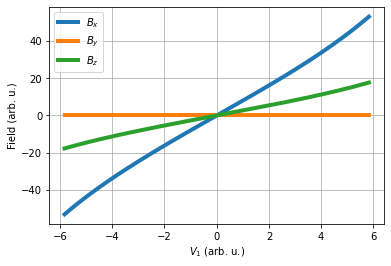

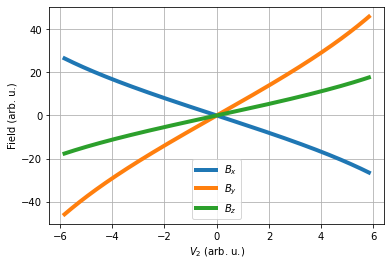

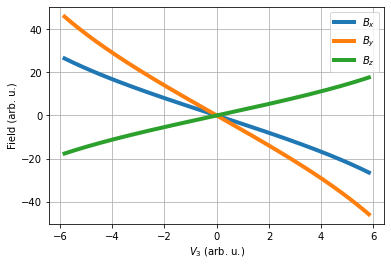

In [31]:
ax1 = B_vs_V(V1, Bx, By, Bz)
ax1.set_xlabel(r'$V_1$ (arb. u.)')

ax2 = B_vs_V(V2, Bx, By, Bz)
ax2.set_xlabel(r'$V_2$ (arb. u.)')

ax3 = B_vs_V(V3, Bx, By, Bz)
ax3.set_xlabel(r'$V_3$ (arb. u.)')

## 'Deep' learning

### Load and prepare data

In [35]:
# Training data
df_train = pd.read_csv('data/full_calibration_set.csv')
V_train = df_train[['V_1', 'V_2', 'V_3']]
B_train = df_train[['B_x', 'B_y', 'B_z']]

# Validation data
df_val = pd.read_csv('data/validation_set.csv')
V_val = df_val[['V_1', 'V_2', 'V_3']]
B_val = df_val[['B_x', 'B_y', 'B_z']]

### Create and train neural network

In [37]:
# Initialize model
model = keras.models.Sequential([
    keras.layers.Dense(3),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dense(3)
])

In [38]:
# Compile model
model.compile(loss="mse", optimizer = keras.optimizers.Adam(), metrics=["mae"])

In [39]:
# Add callbacks

# Stops training if the mean absolute error does not improve for 300 epochs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=500, monitor='val_mae',restore_best_weights=True)
# Saves the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath="models.hdf5",save_best_only=True, monitor='val_mae')

In [40]:
# Train model
history = model.fit(B_train, V_train, epochs=2000, validation_data=(B_val, V_val),batch_size=8,callbacks=[checkpoint_cb, early_stopping_cb]);

Epoch 1/2000
438/438 [==============================] - 4s 3ms/step - loss: 29.2827 - mae: 3.2761 - val_loss: 2.9756 - val_mae: 1.1633
Epoch 2/2000
438/438 [==============================] - 1s 3ms/step - loss: 0.9065 - mae: 0.5541 - val_loss: 0.7550 - val_mae: 0.4347
Epoch 3/2000
438/438 [==============================] - 1s 3ms/step - loss: 0.4252 - mae: 0.3764 - val_loss: 0.4992 - val_mae: 0.3623
Epoch 4/2000
438/438 [==============================] - 1s 3ms/step - loss: 0.2655 - mae: 0.3031 - val_loss: 0.3461 - val_mae: 0.3448
Epoch 5/2000
438/438 [==============================] - 2s 4ms/step - loss: 0.1755 - mae: 0.2453 - val_loss: 0.2313 - val_mae: 0.2846
Epoch 6/2000
438/438 [==============================] - 1s 3ms/step - loss: 0.1252 - mae: 0.2091 - val_loss: 0.1671 - val_mae: 0.2528
Epoch 7/2000
438/438 [==============================] - 1s 3ms/step - loss: 0.0856 - mae: 0.1748 - val_loss: 0.1188 - val_mae: 0.2139
Epoch 8/2000
438/438 [==============================] - 1s 3m

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\trety\anaconda3\envs\qutip\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\trety\AppData\Local\Temp/ipykernel_10576/2458037490.py", line 2, in <module>
    history = model.fit(B_train, V_train, epochs=2000, validation_data=(B_val, V_val),batch_size=8,callbacks=[checkpoint_cb, early_stopping_cb]);
  File "C:\Users\trety\anaconda3\envs\qutip\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\trety\anaconda3\envs\qutip\lib\site-packages\keras\engine\training.py", line 1376, in fit
    for step in data_handler.steps():
  File "C:\Users\trety\anaconda3\envs\qutip\lib\site-packages\keras\engine\data_adapter.py", line 1246, in steps
    original_spe = self._steps_per_execution.numpy().item()
  File "C:\Users\trety\anaconda3\envs\qutip\lib\site-packages\tensorflow\python\o

TypeError: object of type 'NoneType' has no len()

(0.0, 0.5)

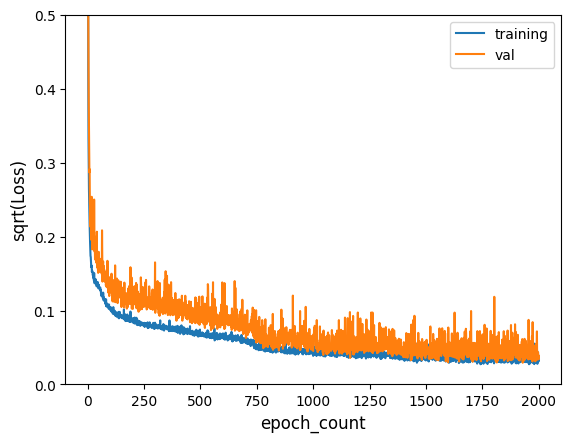

In [33]:
# Plot training process

h = history.history

training_loss = np.array(h["loss"])
test_loss = np.array(h["val_loss"])
epoch_count = np.arange(len(training_loss)) + 1

fig, ax = plt.subplots()
ax.plot(epoch_count, np.sqrt(training_loss), label='training')
ax.plot(epoch_count, np.sqrt(test_loss), label='val')
ax.set_xlabel(r'epoch_count', fontsize=12)
ax.set_ylabel(r'sqrt(Loss)', fontsize=12)
ax.legend(loc=0)
ax.set_ylim(0, 0.5)

In [34]:
# Save model
model.save('data/model.h5')

## Test

In [35]:
# Test field

# Rotation angle
theta = np.linspace(0, 4*np.pi, 151)
B_test = []

for th in theta:
    B_test.append(1 * np.array([np.sin(th), 0, np.cos(th)]))

B_test = np.array(B_test)

In [36]:
V_test = model.predict(B_test)
V_test = np.tanh(V_test/nf)*10

5/5 [==============================] - 0s 1ms/step


In [39]:
B_predict = []
for V in V_test:
    B_predict.append(np.dot(M, V))

B_predict = np.array(B_predict)

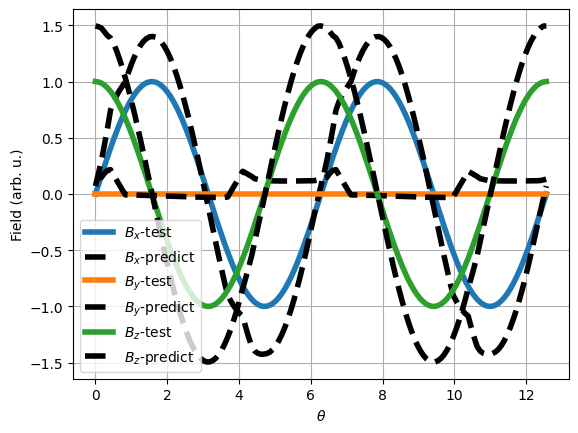

In [40]:
# Plot
fig, ax = plt.subplots()
ax.plot(theta, B_test[:,0], label=r'$B_x$-test', linewidth=4.0)
ax.plot(theta, B_predict[:,0], label=r'$B_x$-predict', linewidth=4.0, color='black', ls='--')

ax.plot(theta, B_test[:,1], label=r'$B_y$-test', linewidth=4.0)
ax.plot(theta, B_predict[:,1], label=r'$B_y$-predict', linewidth=4.0, color='black', ls='--')

ax.plot(theta, B_test[:,2], label=r'$B_z$-test', linewidth=4.0)
ax.plot(theta, B_predict[:,2], label=r'$B_z$-predict', linewidth=4.0, color='black', ls='--')

ax.set_xlabel(r'$\theta$')
ax.set_ylabel('Field (arb. u.)' )
#ax.set_xlim(0,1)
ax.legend(loc=0)
ax.grid()

In [5]:
from generate_field import total_field

In [7]:
# Constants and the setup parameters

mu0 = 10**-7# magnetic constant
m = 1e8 # Scaling factor magnetic dipole magnitude

# Magnetic dipole position vectors
R1 = np.array([1, 0, 1])
R2 = np.array([-np.cos(np.pi/3), np.sin(np.pi/3), 1])
R3 = np.array([-np.cos(np.pi/3), -np.sin(np.pi/3), 1])

# Magnetic dipole orientation (same for all three)
A = np.array([0, 0, 1]) # It is a global variable

# The magnetometer location. Magnetic field is calculated here
r0 = np.array([0., 0., 0.])

V = np.array([1, 0, 0])
B = total_field(r0, V * m, A)

In [8]:
B

array([5.30330086, 0.        , 1.76776695])